In [1]:
print("Hello World")

Hello World


In [12]:
import numpy as np
import matplotlib.pyplot as plt   
import pickle as pkl
from atasi import AtasiNet     

In [3]:

fc = 14.25e9 #Hz
lambda_c = 0.021 #m
delta_D = 0.084 #m
R0 = 400 #m
theta = 45*np.pi/180 #rad
n_antennas = 8 #number of antennas
n_samples = 1000 #number of samples
n_grids = 200 #number of grids (of different height cells)
max_height = 200 #m

In [18]:
def generate_backscatter_coefficients(height=None):
	if height == None : 
		height = np.random.choice([k for k in range(200)])
	A = min(max(np.abs(np.random.rayleigh(scale=2, size=1)[0]), 1), 4)

	phi = np.random.uniform(0, 2 * np.pi, size=1)[0]
	gamma_ = A * np.exp(1j * phi)
	gamma = np.zeros(n_grids,dtype=complex)
	gamma[height] = gamma_
	return gamma

#referred to as A in the model implementation part
#baselines in gamma-net go from -135 to 135 in 25 steps
def compute_baseline_lengths():
    return np.linspace (-135,135,25)

def compute_measurement_matrix(baselines, num_grids, wavelength, R0):
    s = np.linspace(0, max_height, num_grids)  
    D = np.exp(1j * 4 * np.pi * np.outer(baselines, s) / (wavelength * R0))
    return D

#ToDo : compute 11 levels of noise with SNR from 0 to 30 dB --> find the right gwn each time
def simulate_backscattered_signal(gamma, D):
    return np.dot(D, gamma)

def double_scatterer(height1,height2):
    gamma1 = generate_backscatter_coefficients(height1)
    gamma2 = generate_backscatter_coefficients(height2)
    gamma = gamma1 + gamma2 
    return gamma

def SNR(signal, noise):
	"""Computes the SNR of a signal
		inputs : 
			signal : the signal
			noise : the noise
		outputs :
			snr : the SNR of the signal
	"""
	signal_power = np.sum(np.abs(signal)**2)
	noise_power = np.sum(np.abs(noise)**2)
	snr = 10 * np.log10(signal_power / noise_power)
	return snr

def noise_for_snr(signal, snr):
	"""Adds the right amount of noise to the signal to reach the desired SNR 
		inputs : 
			signal : the signal to which the noise will be added
			snr : the desired SNR
		outputs :
			noisy_signal : the signal with added noise
	"""
	noise = np.random.normal(0, 1, signal.shape)
	signal_power = np.sum(np.abs(signal)**2)
	noise_power = np.sum(np.abs(noise)**2)
	noise = noise * np.sqrt(signal_power / (10**(snr/10) * noise_power))
	noisy_signal = signal + noise
	return noisy_signal

def generate_gamma(n_scatterers,height=None,scatterers_dist=None) :
	if n_scatterers == 2:

		#no height and resolution specified : generate random heights
		if height == None and scatterers_dist == None :
			height1 = np.random.choice([k for k in range(200)])
			height2 = np.random.choice([k for k in range(200)])
			while height1 == height2:
				height2 = np.random.choice([k for k in range(200)])

		#no height specified but resolution specified : generate random heights with a given distance
		elif height == None and scatterers_dist is not None :
			height1 = np.random.choice([k for k in range(200)])
			height2 = height1 + scatterers_dist 
			if height2 >= max_height : 
				height2 = height1 - scatterers_dist
		
		#height specified
		else : 
			height1 = height[0]
			height2 = height[1]

		return double_scatterer(height1,height2)

		
	elif n_scatterers == 1 : 
		if height is not None and type(height) != int : 
			raise TypeError("If only one scatterer, height must be an integer")
		elif height is None : 
			height = np.random.choice([k for k in range(200)])
		return generate_backscatter_coefficients(height)
	

	else : 
		raise ValueError("Number of scatterers must be one or two")
	


50.0


([<matplotlib.axis.YTick at 0x78f034e97c10>,
 [Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 3.0, '3.0'),
  Text(0, 3.5, '3.5'),
  Text(0, 4.0, '4.0')])

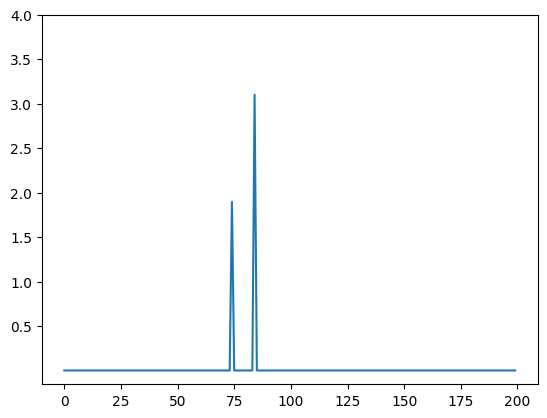

In [47]:
#plot the backscatter coefficients 
#ToDO : make a better more random way of choosing the heights
#ToDO : study rayleigh's resolution and the stuff linked with it in the paper

rayleigh_res = lambda_c*R0/(2*delta_D) #meant to be 50m in the paper
print(rayleigh_res)
n_scatterers = 2
distancing_factor = 0.2 #between 0.1 and 1.2 (times the rayleigh resolution)

gamma = generate_gamma(n_scatterers,scatterers_dist=int(rayleigh_res*distancing_factor))

plt.plot([np.abs(gamma[k]) for k in range(len(gamma))])
plt.yticks([0.5,1,1.5,2,2.5,3,3.5,4])

(25, 200)
[-0.15012834-0.05242083j  2.34263867-1.69865595j  3.35675355+0.39244504j
  0.63594919+0.86977097j -0.28753647-2.11380324j  2.0752934 -2.89444783j
  2.01076437-0.38458421j -1.11903566-0.36664747j -1.46235121-3.08244332j
  0.84017595-2.70275627j  0.01039312+0.18594904j -2.93896313-0.17617418j
 -2.32669376-2.41116296j  0.06690125-0.99166827j -1.15793461+1.87435563j
 -3.43763681+0.92203073j -1.73270615-0.94678908j  0.66829246+1.06803986j
 -0.82953332+3.33441123j -2.31886636+1.52594986j  0.19769213-0.14338975j
  2.19591385+2.03370765j  0.26763832+3.30892659j -0.63246349+0.65424277j
  2.14991549-0.73400461j]


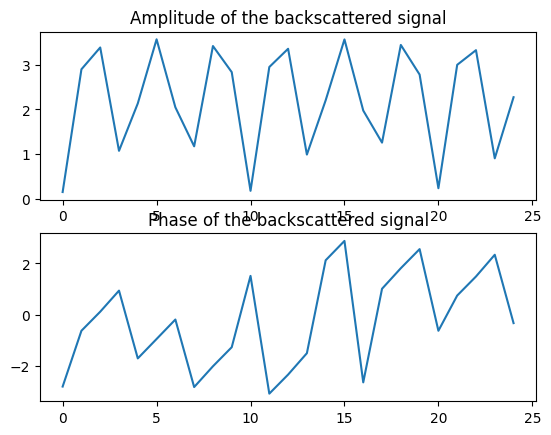

In [11]:
baselines = compute_baseline_lengths()
D = compute_measurement_matrix(baselines, n_grids, lambda_c, R0)
print(D.shape)

#generate y 
y = np.dot(D,gamma)
#ToDO add the noise to have the correct SNR for all the values mentionned
print(y)

f,axes = plt.subplots(2,1)
axes[0].plot([np.abs(y[k]) for k in range(len(y))])
axes[1].plot([np.angle(y[k]) for k in range(len(y))])
axes[0].set_title("Amplitude of the backscattered signal")
axes[1].set_title("Phase of the backscattered signal")
plt.show()



In [7]:

model = AtasiNet(D)
W = model.compute_w()
print(W.shape)
print(D.shape)
score = np.linalg.norm(W.T@D)**2
print(score)


/home/guacaman/.virtualenvs/IMA/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/home/guacaman/.virtualenvs/IMA/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


Norm of W at iteration1: 362.3871341598204
Norm of W at iteration2: 275.58637873878035
Norm of W at iteration3: 46.01692270011769
Norm of W at iteration4: 99.98374956510457
Norm of W at iteration5: 41.268540564272044
Norm of W at iteration6: 50.83364630560059
Norm of W at iteration7: 42.74025368810457
Norm of W at iteration8: 8.53459134318908
Norm of W at iteration9: 7.502831279220097
Norm of W at iteration10: 11.087314171835626
Norm of W at iteration11: 7.038598259088476
Norm of W at iteration12: 7.001041458181019
Norm of W at iteration13: 7.070620244435482
Norm of W at iteration14: 7.003461756954352
Norm of W at iteration15: 6.999980846503675
Norm of W at iteration16: 7.001332013196628
Norm of W at iteration17: 7.000073532304598
(25, 200)
(25, 200)
40.55018388301505


In [14]:
pkl.dump(model, open("./Models/model_W_optimized.pkl", "wb"))

cristiano.ulondumendes@telecom-paris.fr